In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv("telco_train.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churned
0,4950-BDEUX,Male,0,No,No,35,No,No phone service,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,0
1,7993-NQLJE,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,0
2,7321-ZNSLA,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,...,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,0
3,4922-CVPDX,Female,0,Yes,No,26,Yes,No,DSL,No,...,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,0
4,2903-YYTBW,Male,0,Yes,Yes,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,0


In [3]:
print("Shape of data:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum().sum())

print("\nClass Distribution:")
print(df['churned'].value_counts())

Shape of data: (5634, 21)

Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
churned               int64
dtype: object

Missing Values:
0

Class Distribution:
0    4139
1    1495
Name: churned, dtype: int64


In [4]:
# replace blank strings with nan
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
# Convert to float
df['TotalCharges'] = df['TotalCharges'].astype(float)
print("Missing TotalCharges:", df['TotalCharges'].isnull().sum())

Missing TotalCharges: 8


In [5]:
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True)

In [6]:
# Drop customerID (not needed)
df = df.drop('customerID', axis=1)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols.remove('churned')

In [7]:
# One-hot encode of categorical features
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("Final dataset shape after encoding:", df_encoded.shape)
df_encoded.head()

Final dataset shape after encoding: (5626, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,churned,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,35,49.20,1701.65,0,1,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
1,0,15,75.10,1151.55,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,13,40.55,590.35,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,1
3,0,26,73.50,1905.70,0,0,1,0,1,0,...,0,1,0,1,0,1,1,1,0,0
4,0,1,44.55,44.55,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('churned', axis=1)
y = df_encoded['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]

# AUC Scores
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

print("Logistic Regression AUC:", lr_auc)
print("Random Forest AUC:", rf_auc)

Logistic Regression AUC: 0.865751512331317
Random Forest AUC: 0.8329336244645691


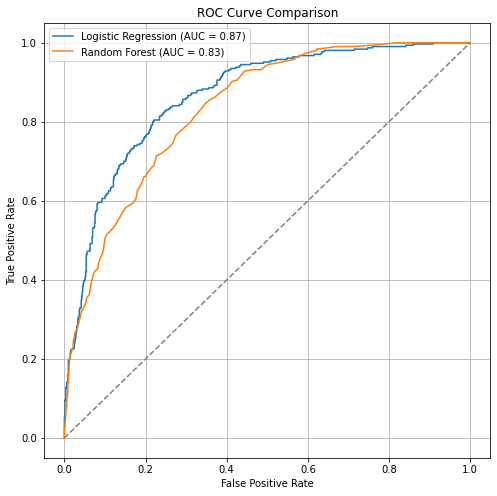

In [10]:
# Plot ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(8,8))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {lr_auc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
test_df = pd.read_csv("telco_test.csv")

test_df['TotalCharges'] = test_df['TotalCharges'].replace(" ", np.nan).astype(float)
test_df = test_df.dropna(subset=['TotalCharges'])
customer_id = test_df['customerID']
test_df = test_df.drop('customerID', axis=1)

test_encoded = pd.get_dummies(test_df, drop_first=True)
test_encoded = test_encoded.reindex(columns=X.columns, fill_value=0)

In [12]:
churn_probs = lr.predict_proba(test_encoded)[:, 1]
predictions = pd.DataFrame({
    'customerID': customer_id,
    'churn_probability': churn_probs
})

predictions.to_csv("predictions.csv", index=False)
predictions.head()

,customerID,churn_probability
0,4376-KFVRS,0.051462
1,2754-SDJRD,0.671750
2,9917-KWRBE,0.057634
3,0365-GXEZS,0.379694
4,9385-NXKDA,0.021329


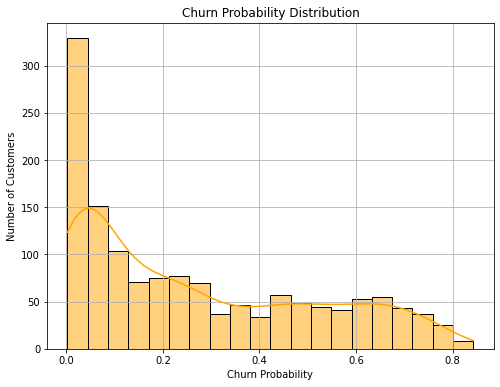

In [24]:
plt.figure(figsize=(8, 6))
sns.histplot(predictions['churn_probability'], bins=20, kde=True, color='orange')
plt.title("Churn Probability Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Number of Customers")
plt.grid(True)
plt.show()

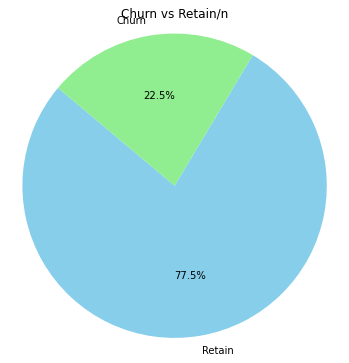

In [29]:
predictions['churn_predicted'] = predictions['churn_probability'].apply(lambda x: 1 if x >= 0.5 else 0)
pie_data = predictions['churn_predicted'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(pie_data, labels=['Retain', 'Churn'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'], startangle=140)
plt.title("Churn vs Retain")
plt.axis('equal')
plt.show()

In [15]:
top_risk = predictions.sort_values(by='churn_probability', ascending=False).head(10)
print("Top 10 High-Risk Customers:")
print(top_risk)

Top 10 High-Risk Customers:
      customerID  churn_probability  churn_predicted
1090  5178-LMXOP           0.843105                1
1221  0295-PPHDO           0.832517                1
627   9057-SIHCH           0.822075                1
647   6023-YEBUP           0.808321                1
1355  6630-UJZMY           0.808069                1
995   8161-QYMTT           0.807203                1
1109  1069-XAIEM           0.805600                1
1164  8884-ADFVN           0.802923                1
889   2545-EBUPK           0.800526                1
1175  6861-XWTWQ           0.799586                1
